# K- Nearest Neighbors

## Project:
Predicting Sales Price of bulldozers sold using previous data by running a model of the KNN. Using iterative Imputation for handling missing values, Label encoding for handling categorical data, and a principal component analysis for feature preprocessing. Details can be found here:

[Blue Book for Bulldozers](https://www.kaggle.com/competitions/bluebook-for-bulldozers/overview)

### Dataset:
* train.csv: The Training set.

* Valid.Csv: The validation set.

* Test.csv : The Test set.

* ValidSolution.csv: contains "SalePrice" i.e the target variable for the validation set.



In [ ]:
import pandas as pd #For data handling.
import numpy as np

import matplotlib.pyplot as plt #For data Visualization
import seaborn as sns

from sklearn.model_selection import train_test_split #For KNN model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error #For evaluating Data
from sklearn.metrics import r2_score

In [ ]:
Train_data=pd.read_csv("Train.csv", low_memory=False)

Val_Data=pd.read_csv("Valid.csv", low_memory=False)

Test_Data=pd.read_csv("Test.csv")

Val_Data_Sol=pd.read_csv("ValidSolution.csv") #for model evaluation

Train_data.head()


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


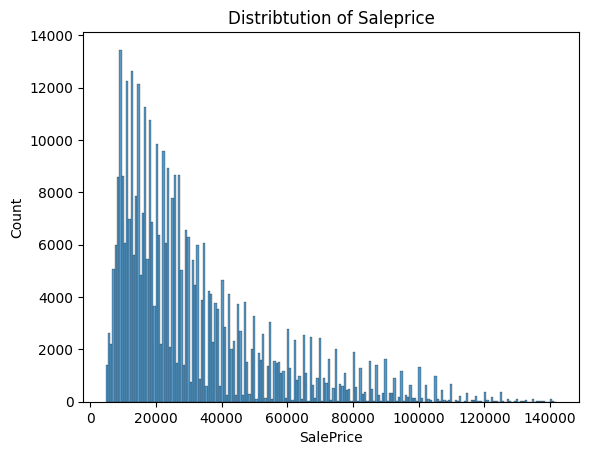

In [ ]:
Train_data.describe() #A basic summary of data statistics
sns.histplot(Train_data['SalePrice']) #Distribution of SalePrice, the target variable we have to predict
plt.title("Distribtution of Saleprice")
plt.show()

In [ ]:
Train_data.info() #checking for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

## Feature Preproccessing
* Using Label Encoding to convert Categorical variables into Numerical ones.Label Encoding assigns a unique integer to each category within a feature, enabling the model to learn from this data. Since most of the columns in the dataset were non-numerical it was essential to use Label Encoding

* Using iterative Imputation for handling missing values and dropping duplicates in Data.  Iterative imputation models each missing feature as a function of other features, repeating the estimation process multiple times. This repetition refines the estimated values, which are then used as inputs in subsequent iterations for predicting other missing values, making it highly effective for datasets with complex relationships among features. https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/

* PCA(Principal Component Analysis) was used to reduce the dimensionality of the dataset. The dataset had a high number of features with multiple columns which resulted in a computational overhead. PCA was hence used to transform the dataset into a new set of Principal Features that capture the maximum variance of data.

In [ ]:
categorical_columns=Train_data.select_dtypes(include=['object']).columns
for columns in categorical_columns:
    label_encoder=LabelEncoder()
    Data=pd.concat([Train_data[columns],Val_Data[columns]],axis=0)#combining train and val_data
    label_encoder.fit(Data)
    Train_data['Encoded_'+columns]=label_encoder.transform(Train_data[columns]) #transforming train and val data
    Val_Data['Encoded_'+columns]=label_encoder.transform(Val_Data[columns])
Train_data.drop(categorical_columns,axis=1,inplace=True) #dropping original categorical columns
Val_Data.drop(categorical_columns,axis=1,inplace=True)

## Using Iterative imputation for handling missing values and removing duplicates in Data
Train_data.drop_duplicates(inplace=True)
Val_Data.drop_duplicates(inplace=True)
Val_Data_Sol.drop_duplicates(inplace=True)


Imputer=IterativeImputer()
columns=Train_data.select_dtypes(include=['int64','float64']).columns
feature_columns=[col for col in columns if col != 'SalePrice'] #isolating feature columns
Train_data[feature_columns]=Imputer.fit_transform(Train_data[feature_columns])
Val_Data[feature_columns]=Imputer.transform(Val_Data[feature_columns])


##Scaling the data
Scalar=StandardScaler()
Train_data[feature_columns]=Scalar.fit_transform(Train_data[feature_columns])
Val_Data[feature_columns]=Scalar.transform(Val_Data[feature_columns])


pca=PCA(n_components=0.85) #Retaining 85% of the datasets variance
new_Train_Data=pca.fit_transform(Train_data[feature_columns])
new_Val_Data=pca.transform(Val_Data[feature_columns])

## Model Evaluation
### For evaluating the model performance multiple error metrics were used:
* Mean absolute error(mse) and root mean squared error(rmse) were used to provide a direct measure in the average prediction of the target variable(the 'Saleprice').

* The R2 score was also calculated to determine the proportion of variance in the predicted label.

* The root mean squared log error(rmsle) was also used which was the official metric usd in the Bluebook for bulldozers competition. rmsle penalizes underestimates more than overestimates which is crucial in terms of auction saleprice predictions.


In [ ]:
knn=KNeighborsRegressor(n_neighbors=9)
knn.fit(new_Train_Data, Train_data['SalePrice'])
val_predictions=knn.predict(new_Val_Data)
mae=mean_absolute_error(Val_Data_Sol['SalePrice'],val_predictions)
rmse=mean_squared_error(Val_Data_Sol['SalePrice'],val_predictions, squared=False)
print("MAE: ",mae, "RMSE: ",rmse)

r2=r2_score(Val_Data_Sol['SalePrice'], val_predictions)
print("R2 score: ",r2)

rmsle=np.sqrt(np.mean(np.square(np.log1p(val_predictions) - np.log1p(Val_Data_Sol['SalePrice']))))
print("RMSLE: ",rmsle)

MAE:  12382.936987432433 RMSE:  17951.455285231357
R2 score:  0.5308375466756369
RMSLE:  0.48007305056633265


## Visualizing Output
* Using a Scatter plot to draw a line of best fit between the Predicted and the Actual Prices.

* Points on the or closer to the green line have a better accuracy.

* Plot shows that the model does not predict price accurately for higher prices, that could be rectified by better preprocessing(e.g removing anomalies in the data).

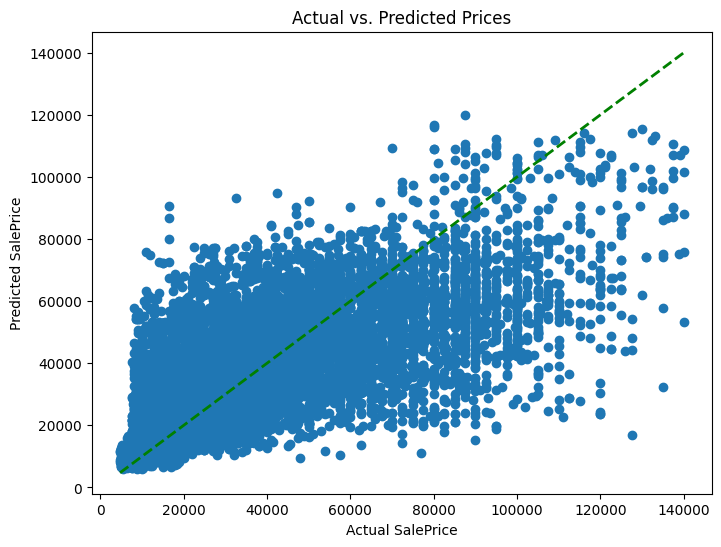

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(Val_Data_Sol['SalePrice'], val_predictions)
plt.plot([Val_Data_Sol['SalePrice'].min(), Val_Data_Sol['SalePrice'].max()],
         [Val_Data_Sol['SalePrice'].min(), Val_Data_Sol['SalePrice'].max()],
         '--g', linewidth=2)
plt.title('Actual vs. Predicted Prices')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.show()


## Final Prediction on the Test Dataset:

In [ ]:
Train_data=pd.read_csv("Train.csv",low_memory=False)
Test_Data=pd.read_csv("Test.csv")
for columns in categorical_columns: ##applying same preprocessing steps on Test dataset
    Data=pd.concat([Train_data[columns],Test_Data[columns]])
    label_encoder.fit(Data)
    Test_Data['Encoded_'+columns]=label_encoder.transform(Test_Data[columns])
Test_Data.drop(categorical_columns,axis=1,inplace=True)

Test_Data[feature_columns]=Imputer.transform(Test_Data[feature_columns])

Test_Data[feature_columns]=Scalar.transform(Test_Data[feature_columns])

new_Test_Data=pca.transform(Test_Data[feature_columns])

Test_Predictions=knn.predict(new_Test_Data)

Test_Data=pd.read_csv("Test.csv")
Test_Data['SalePrice']=Test_Predictions
display(Test_Data[['SalesID', 'SalePrice']])
# Test_Data.head()



,SalesID,SalePrice
0,1227829,20611.111111
1,1227844,39111.111111
2,1227847,67111.111111
3,1227848,81666.666667
4,1227863,38055.555556
...,...,...
12452,6643171,17111.111111
12453,6643173,9750.000000
12454,6643184,16783.333333
12455,6643186,9583.333333
